# Исследование сервиса аренды самокатов GoFast

В основных данных есть информация о пользователях, их поездках и подписках.

**Цель исследования:**

1. Понять тратят ли пользователи с подпиской больше времени на поездки?

2. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше оптимальных 3130 метров?

3. Будет ли выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки?

4. Снизилось ли количество обращений в техподдержку после обновления сервера?

5. Выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%.

6. Оценить вероятность того, что разосланные 1 млн push уведомлений откроют не более 399,5 тыс. пользователей.

**Ход исследования**

Данные для исследования я получу из трех файлов: пользователи — `users_go.csv`, поездки — `rides_go.csv`, подписки — `subscriptions_go.csv`. О качестве данных пока ничего не известно, поэтому перед началом работы понадобится обзор данных. 

Я проверю данные на ошибки и оценю их влияние на исследование. Затем, на этапе предобработки я поищу возможность исправить все ошибки данных, которые не приведут к искажению конечного результата. Далее создам необходимые объединенные таблицы и необходимые столбцы и приступлю к исследовательскому анализу.

**Таким образом, моё исследование пройдет в несколько этапов:**

- Обзор данных.

- Предобработка данных.

- Описание и визуализация общей информации о пользователях и поездках.

- Объединение данных о пользователях, поездках и подписках в один датафрейм.

- Подсчёт выручки.

- Проверка гипотез из целей исследования.

- Написание общего вывода по полученным данным.


### Откроем файлы с данными и изучим общую информацию. 

#### Считаем данные из csv-файлов и сохраним в переменные.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import binom, norm
from math import factorial, sqrt
import math

In [2]:
try:
    users_go = pd.read_csv('users_go.csv')
except:
    users_go = pd.read_csv('https://drive.google.com/file/d/1UVM8J87eeEs42jFNVJQgppdhGzPvX-JM/view?usp=sharing')

In [3]:
try:
    rides_go = pd.read_csv('rides_go.csv')
except:
    rides_go = pd.read_csv('https://drive.google.com/file/d/1PjQ01ESVvK8U2JNH2TJm3z6rBYgtDpHv/view?usp=sharing')

In [4]:
try:
    subscriptions_go = pd.read_csv('subscriptions_go.csv')
except:
    subscriptions_go = pd.read_csv('https://drive.google.com/file/d/1ap_y8BlmNKyyJyPkmMfUXFYt6tOPPsZY/view?usp=sharing')

#### Выведем первые 20 строчек и общую информацию датафреймов `users_go`, `rides_go`, `subscriptions_go` на экран.

In [5]:
users_go.head(20)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [6]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
rides_go.head(20)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [8]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [9]:
subscriptions_go.head(20)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [10]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


#### Построим гистограммы для всех числовых столбцов датафреймов `users_go` и `rides_go`.

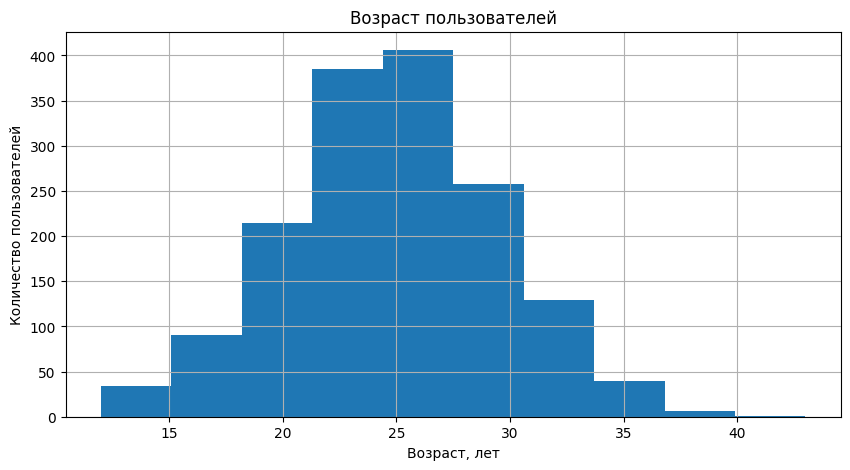

In [11]:
users_go.hist('age', figsize=(10, 5))
plt.title('Возраст пользователей')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество пользователей')
plt.show()

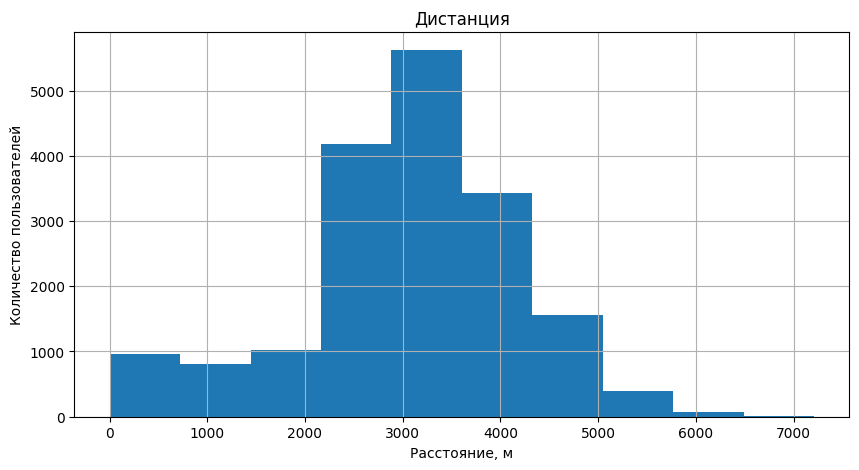

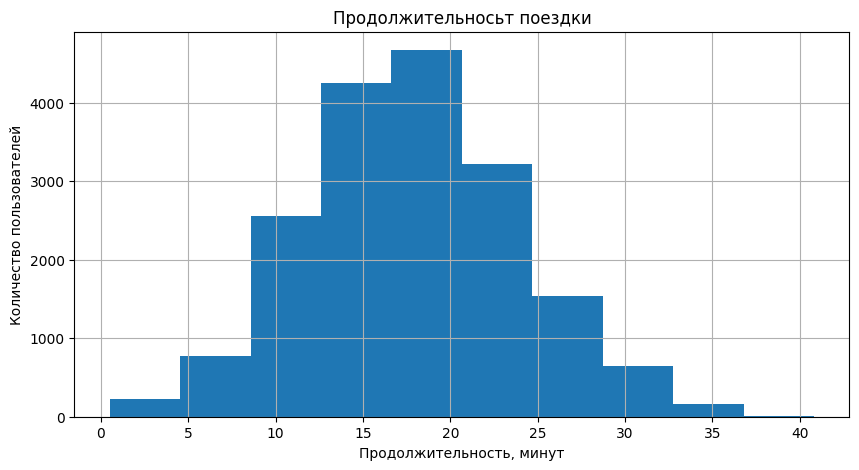

In [12]:
rides_go.hist('distance', figsize=(10, 5))
plt.title('Дистанция')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество пользователей')
plt.show()
rides_go.hist('duration', figsize=(10, 5))
plt.title('Продолжительносьт поездки')
plt.xlabel('Продолжительность, минут')
plt.ylabel('Количество пользователей')
plt.show()

**Вывод, исходя из общих данных датафреймов `users_go`, `rides_go`, `subscriptions_go`:**
1. пропусков нет, что хорошо;
2. необходимо проверить наличие дубликатов;
4. по гистограммам не видны какие-то большие разбросы данных или выбросы.

### Предобработка данных

#### Изменим тип данных для столбца *date* датафрейма `rides_go` на <u>datetime<u>.

In [13]:
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')

In [14]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


#### Проверим количество дубликатов в датафреймах `users_go`, `rides_go`.

In [15]:
print('Количество дубликатов:', rides_go.duplicated().sum())

Количество дубликатов: 0


In [16]:
print('Количество дубликатов:', users_go.duplicated().sum())

Количество дубликатов: 31


**Удалим дубликаты в датафрейме `users_go`.**

In [17]:
users_go = users_go.drop_duplicates().reset_index(drop=True)
print('Количество дубликатов:', users_go.duplicated().sum())

Количество дубликатов: 0


#### Определим месяц в столбце *date* и добавим данные в новый столбец *month_number*.

In [18]:
rides_go['month_number'] = rides_go['date'].dt.month

#### Преобразуем данные в столбцах *distance* и *duration*. Для *distance* округлим до 1 знака после точки, для *duration* округлим данные до целого числа и поменяем тип данных на <u>int<u>.

In [19]:
rides_go['distance'] = rides_go['distance'].round(1)

In [20]:
rides_go['duration'] = np.ceil(rides_go['duration']).astype(int)

In [21]:
rides_go.head()

,user_id,distance,duration,date,month_number
0,1,4409.9,26,2021-01-01,1
1,1,2617.6,16,2021-01-18,1
2,1,754.2,7,2021-04-20,4
3,1,2694.8,19,2021-08-11,8
4,1,4028.7,27,2021-08-28,8


In [22]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       18068 non-null  int64         
 1   distance      18068 non-null  float64       
 2   duration      18068 non-null  int32         
 3   date          18068 non-null  datetime64[ns]
 4   month_number  18068 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2)
memory usage: 635.3 KB


**Вывод по предобработке:**

- в исходных данных датафрейма `users_go` были обнаружены и удалены дубликаты.

- тип данных для столбца *date* датафрейма `rides_go` быд изменен на datetime для удобства дальнейшего исследования.

- был добавлен новый столбец в датафрейм `rides_go` с номером месяца - *month_number*.

- в датафрейме `rides_go` в столбцах *distance* и *duration* были округлены значения для удобства дальнейшего исследования.

В целом данные в хорошем качестве, таблицы готовы к дальнейшему исследованию.

### Исследовательский анализ данных

#### Рассмотрим частоту встречаемости городов.

In [23]:
users_go_grouped = users_go.groupby('city')['city'].count()

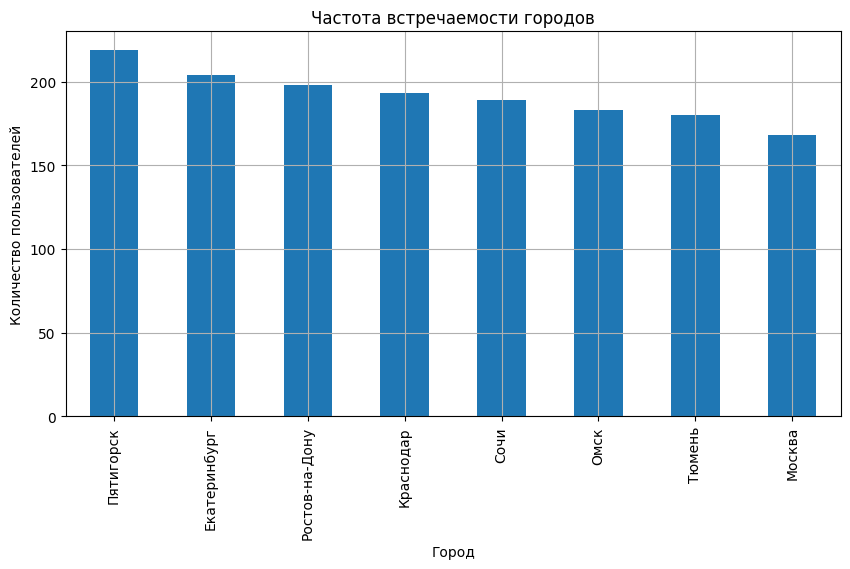

In [24]:
users_go_grouped.sort_values(ascending=False).plot(
    x='city', 
    kind='bar', 
    figsize=(10, 5), 
    grid=True,
    title = 'Частота встречаемости городов'
)
plt.xlabel('Город')
plt.ylabel('Количество пользователей')
plt.show()

**По графику видно, что наиболее часто пользуются сервисом аренды самокатов в Пятигорске, а наименее - в Москве. Можно предположить, что это связанно с тем, что по Москве быстрее и дешевле передвигаться общественным транспортом (автобус, метро), а в Пятигорске аренда самоката является хорошей альтернативой общественному транспорту.**

#### Рассмотрим соотношение пользователей с подпиской и без подписки.

Создадим сводную таблицу по датафрейму `users_go`, где индексом таблицы будет столбец *subscription_type*, значение таблицы будет считаться по столбцу *user_id*. Найдем количество людей с подпиской и без (*count*) и затем посчитаем долю людей с подпиской и без (*share, %*).

In [25]:
subscription_type_pivot = users_go.pivot_table(index=['subscription_type'], values='user_id', aggfunc=['count'])

In [26]:
subscription_type_pivot = subscription_type_pivot.reset_index().droplevel(1, axis=1)

In [27]:
subscription_type_pivot['share, %'] = (subscription_type_pivot['count'] / users_go['user_id'].count().sum()) * 100 
subscription_type_pivot

,subscription_type,count,"share, %"
0,free,835,54.432855
1,ultra,699,45.567145


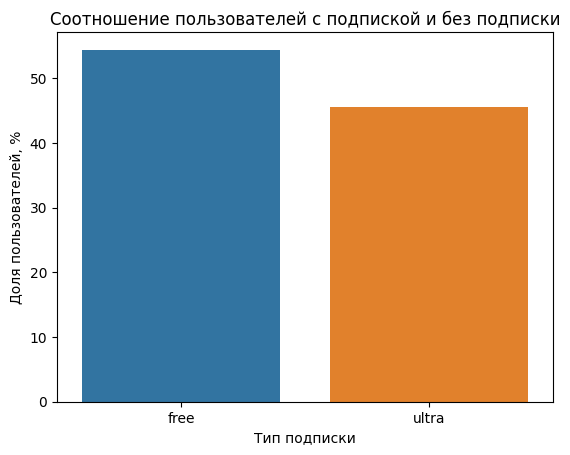

In [28]:
sns.barplot(
    x=subscription_type_pivot['subscription_type'], 
    y=subscription_type_pivot['share, %'],
)
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.xlabel('Тип подписки')
plt.ylabel('Доля пользователей, %')
plt.show()

**Доля людей без подписки (54.4%) больше, чем людей с подпиской (45.6%).**

**Рассмотрим еще одну сводную таблицу, выделив людей с подпиской и без подписки по городам.**

In [29]:
subscription_type_city_pivot = users_go.pivot_table(
    index=['city'], 
    columns='subscription_type', 
    values='user_id', 
    aggfunc=['count']
)

In [30]:
subscription_type_city_pivot.columns = ['free', 'ultra']

In [31]:
subscription_type_city_pivot = subscription_type_city_pivot.reset_index()

In [32]:
subscription_type_city_pivot = subscription_type_city_pivot.sort_values(by='free', ascending=False).reset_index(drop=True)

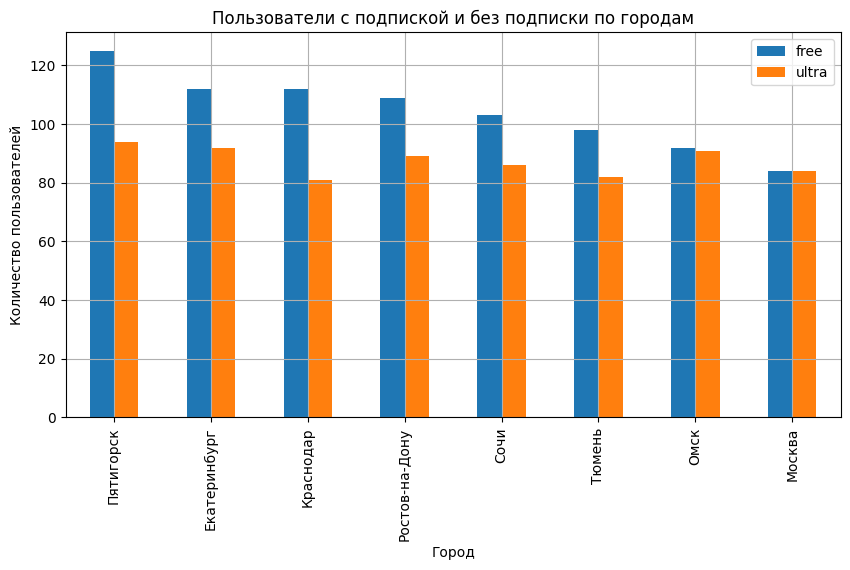

In [33]:
subscription_type_city_pivot.plot(
    x='city', 
    kind='bar', 
    figsize=(10, 5), 
    grid=True,
    title = 'Пользователи с подпиской и без подписки по городам'
)
plt.xlabel('Город')
plt.ylabel('Количество пользователей')
plt.show()

**Также можем увидеть, что людей без подписки больше, чем с подпиской (только в Мосвке их равное количество).**

#### Рассмотрим возраст пользователей.

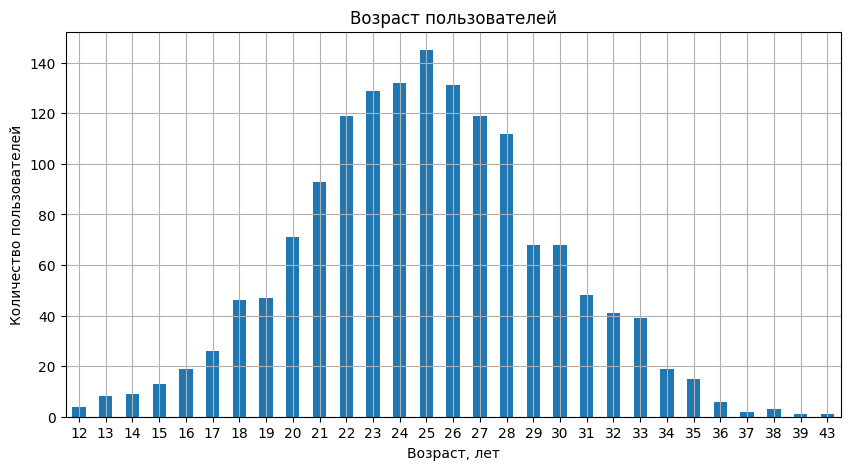

In [34]:
users_go.groupby('age')['age'].count().plot(
    x='age', 
    kind='bar', 
    figsize=(10, 5), 
    grid=True,
    title = 'Возраст пользователей'
)
plt.xticks(rotation=0)
plt.xlabel('Возраст, лет')
plt.ylabel('Количество пользователей')
plt.show()

In [35]:
print('Медиана возраста пользователей:', users_go['age'].median())
print('Среднее возраста пользователей:', users_go['age'].mean())

Медиана возраста пользователей: 25.0
Среднее возраста пользователей: 24.903520208604956


**Большинство пользователей сервиса аренды самокатов в возрасте 25 лет, причем этот возраст является и средней и медианой данных. Самому юному самокатчику 12 лет, самому старшему - 43 года.**

#### Рассмотрим расстояние, которое пользователь преодолел за одну поездку.

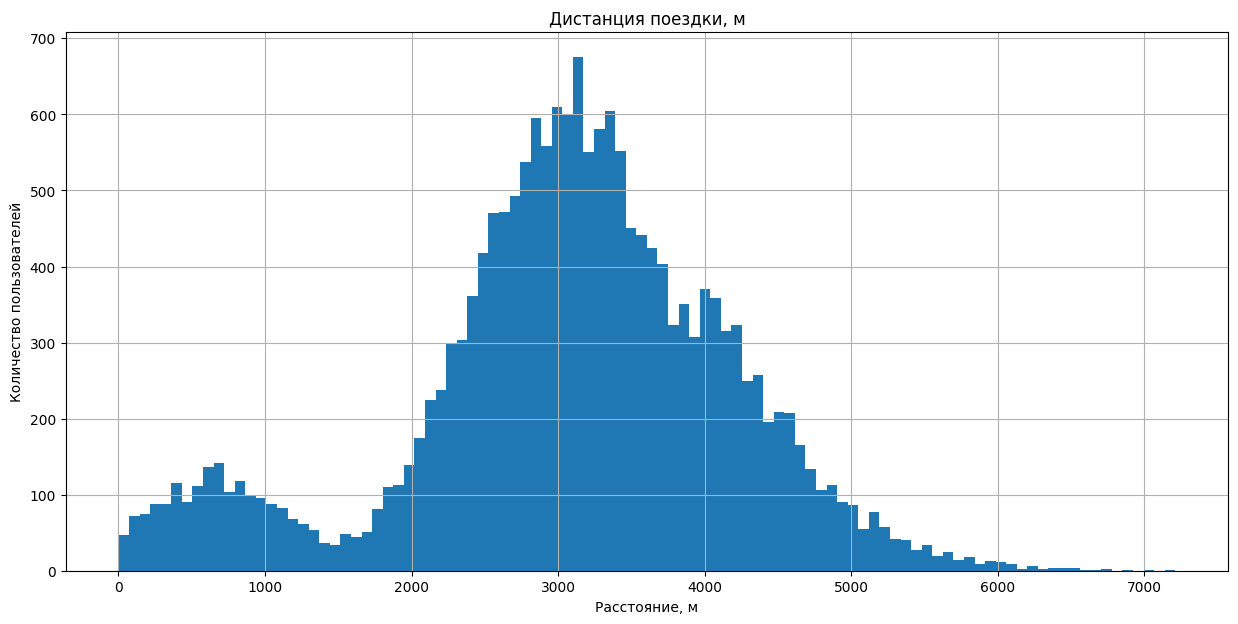

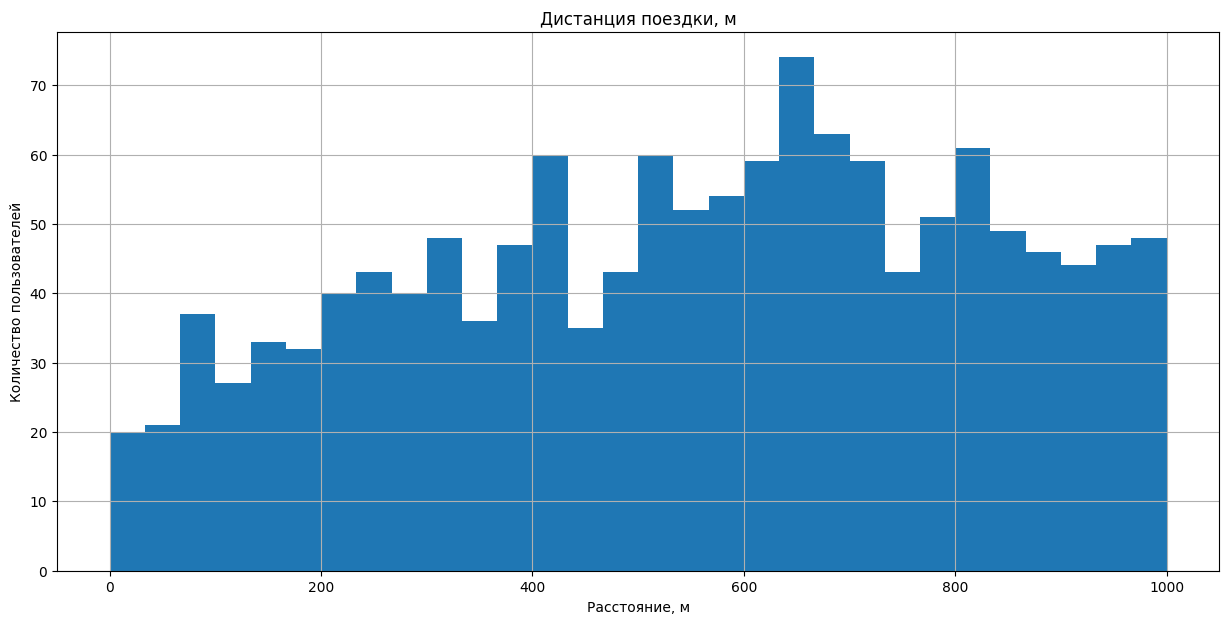

In [36]:
rides_go.hist('distance', bins=100, figsize=(15, 7))
plt.title('Дистанция поездки, м')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество пользователей')
plt.show()
rides_go.hist('distance', bins=30, range=(0, 1000), figsize=(15, 7))
plt.title('Дистанция поездки, м')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество пользователей')
plt.show()

In [37]:
print('Медиана дистанции:', rides_go['distance'].median())
print('Среднее дистанции:', rides_go['distance'].mean())

Медиана дистанции: 3133.6
Среднее дистанции: 3070.6598406021694


**По гистограмме видно, что есть один пик на дистанции от 0 до 1000 метров, возможно это люди, которые увидев возможность проехать с ветерком несколько метров, не отказывают себе в этом удовольствии. И есть второй пик, где-то в среднем на дистанции 2500 - 3500 метров - большинство людей, кто использует аренду самокатов ездят на такую дистанцию. Есть аномальные значения около нуля метров, возможно это ошибка в данных или самокат был активирован полльзователем, но в итоге никуда не поехал.**

#### Рассмотрим продолжительность поездок.

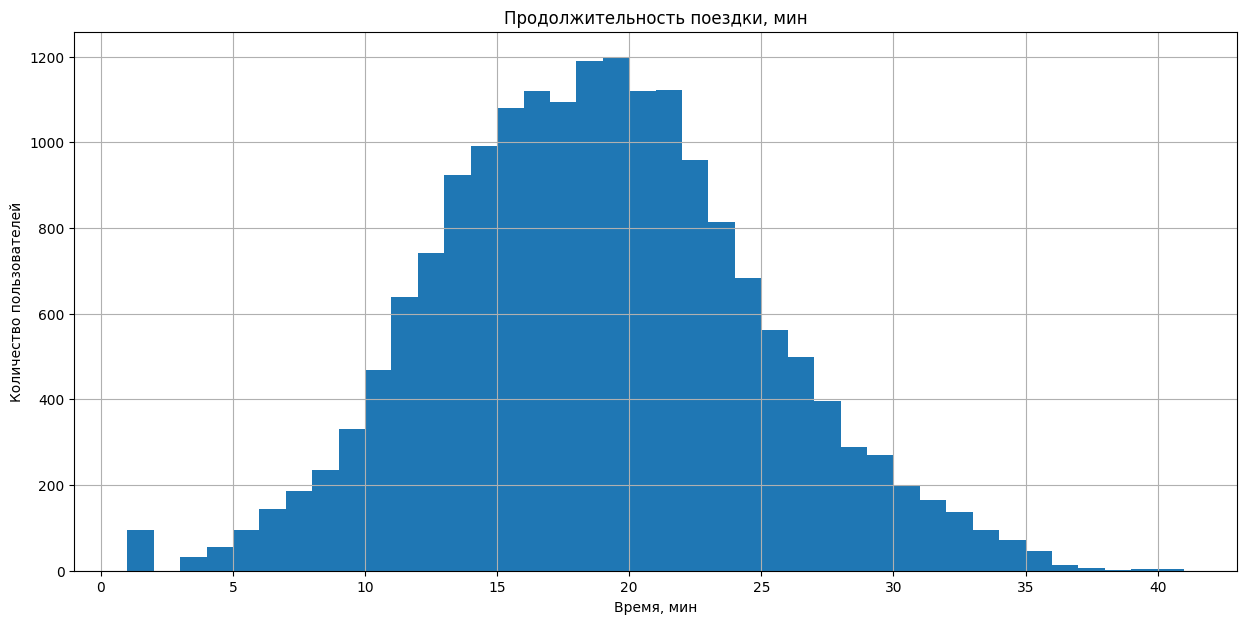

In [38]:
rides_go.hist('duration', bins=40, figsize=(15, 7))
plt.title('Продолжительность поездки, мин')
plt.xlabel('Время, мин')
plt.ylabel('Количество пользователей')
plt.show()

In [39]:
print('Медиана продолжительности поездки:', rides_go['duration'].median())
print('Среднее продолжительности поездки:', rides_go['duration'].mean())

Медиана продолжительности поездки: 18.0
Среднее продолжительности поездки: 18.30352003542174


**Среднее время использования сервиса аренды самокатов составляет 18 минут.**

### Объединение данных

#### Объединим данные о пользователях, поездках и подписках в один датафрейм `df_merge`.

**Сначала объединим `users_go` и `rides_go` в датафрейм `df_merge_1` по общему столбцу *user_id*, затем к получившемуся датафрейму добавим датафрейм `subscription_type` по общему столбцу *subscription_type*.**

In [40]:
df_merge = users_go.merge(rides_go, on='user_id').merge(subscriptions_go, on='subscription_type')

In [41]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  int32         
 7   date               18068 non-null  datetime64[ns]
 8   month_number       18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(6), object(3)
memory usage: 1.7+ MB


In [42]:
df_merge

,user_id,name,age,city,subscription_type,distance,duration,date,month_number,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.9,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.6,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.2,7,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.8,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.7,27,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.1,20,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.4,22,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.2,19,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.3,17,2021-11-27,11,8,50,0


**Проверим размеры таблицы до и после объединения и удостоверимся, что ничего не потерялось.**

In [43]:
print('Размер таблицы user_go:', users_go.shape)
print('Размер таблицы rides_go:', rides_go.shape)
print('Размер таблицы subscriptions_go:', subscriptions_go.shape)
print('Размер объединенной таблицы df_merge:', df_merge.shape)

Размер таблицы user_go: (1534, 5)
Размер таблицы rides_go: (18068, 5)
Размер таблицы subscriptions_go: (2, 4)
Размер объединенной таблицы df_merge: (18068, 12)


**Количество строк в таблицах `rides_go` и `df_merge` совпадают, количество столбцов также совпадает (14 столбцов всего и минус 2 столбца общих, по которым объединялись таблицы).**

#### Создадим ещё два датафрейма: `df_merge_free` - пользователи без подписки, `df_merge_ultra` - пользователи с подпиской.

In [44]:
df_merge_free = df_merge.query('subscription_type == "free"')
df_merge_free

,user_id,name,age,city,subscription_type,distance,duration,date,month_number,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.7,15,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.9,17,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.4,21,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.9,10,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.4,18,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.1,20,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.4,22,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.2,19,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.3,17,2021-11-27,11,8,50,0


In [45]:
df_merge_ultra = df_merge.query('subscription_type == "ultra"')
df_merge_ultra

,user_id,name,age,city,subscription_type,distance,duration,date,month_number,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.9,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.6,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.2,7,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.8,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.7,27,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.0,25,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.7,16,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.2,15,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.8,16,2021-10-17,10,6,0,199


**Сумма строк в двух созданных таблицах равна количеству строк в объединенной таблице - значит все строки попали в нужные нам срезы (11568 + 6500 = 18068).**

#### Рассмотрим датафреймы `df_merge_free` - пользователи без подписки и `df_merge_ultra` - пользователи с подпиской. Построим гистограммы для столбцов *distance* и *duration*.

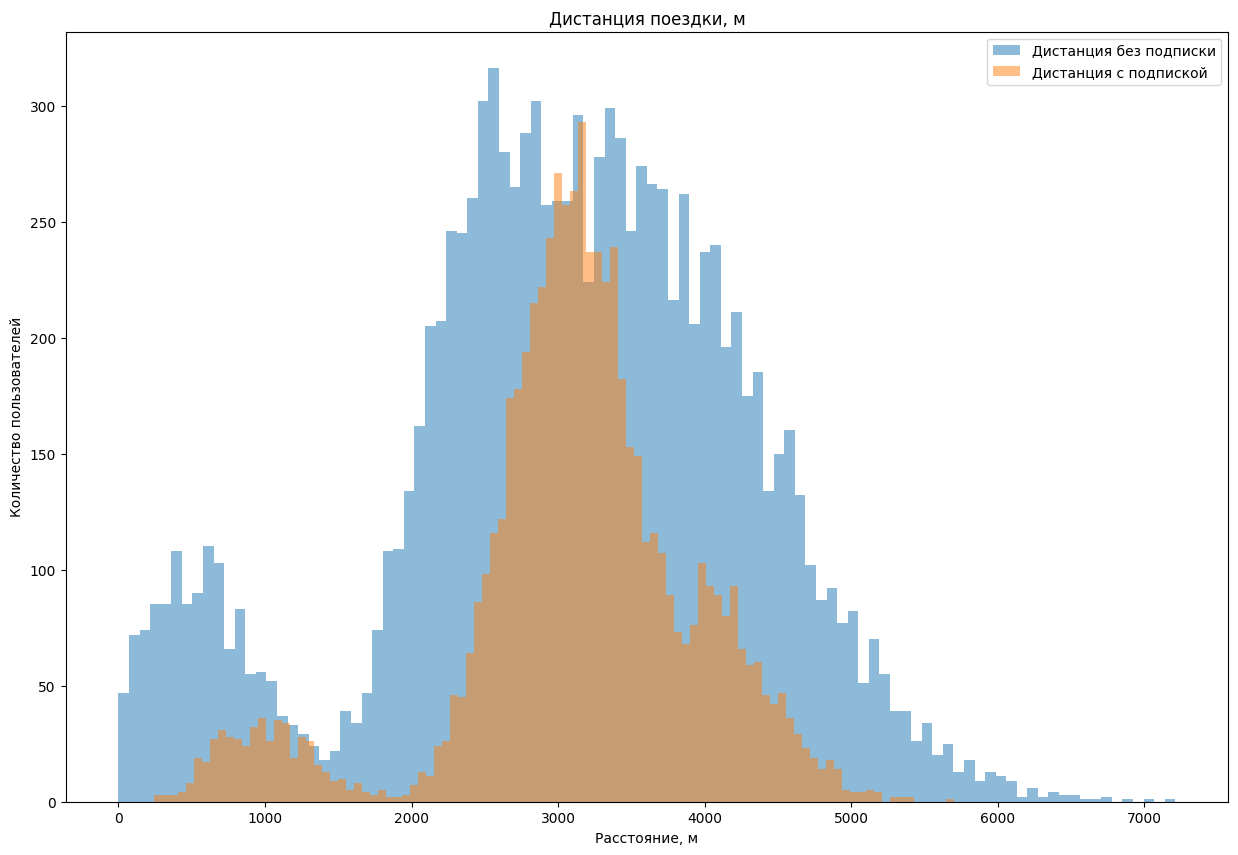

In [46]:
plt.figure(figsize=(15,10))
plt.hist(df_merge_free['distance'], alpha = 0.5, bins=100, label='Дистанция без подписки')
plt.hist(df_merge_ultra['distance'], alpha = 0.5, bins=100, label='Дистанция с подпиской')
plt.legend(loc='upper right')
plt.title('Дистанция поездки, м')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество пользователей')
plt.show()

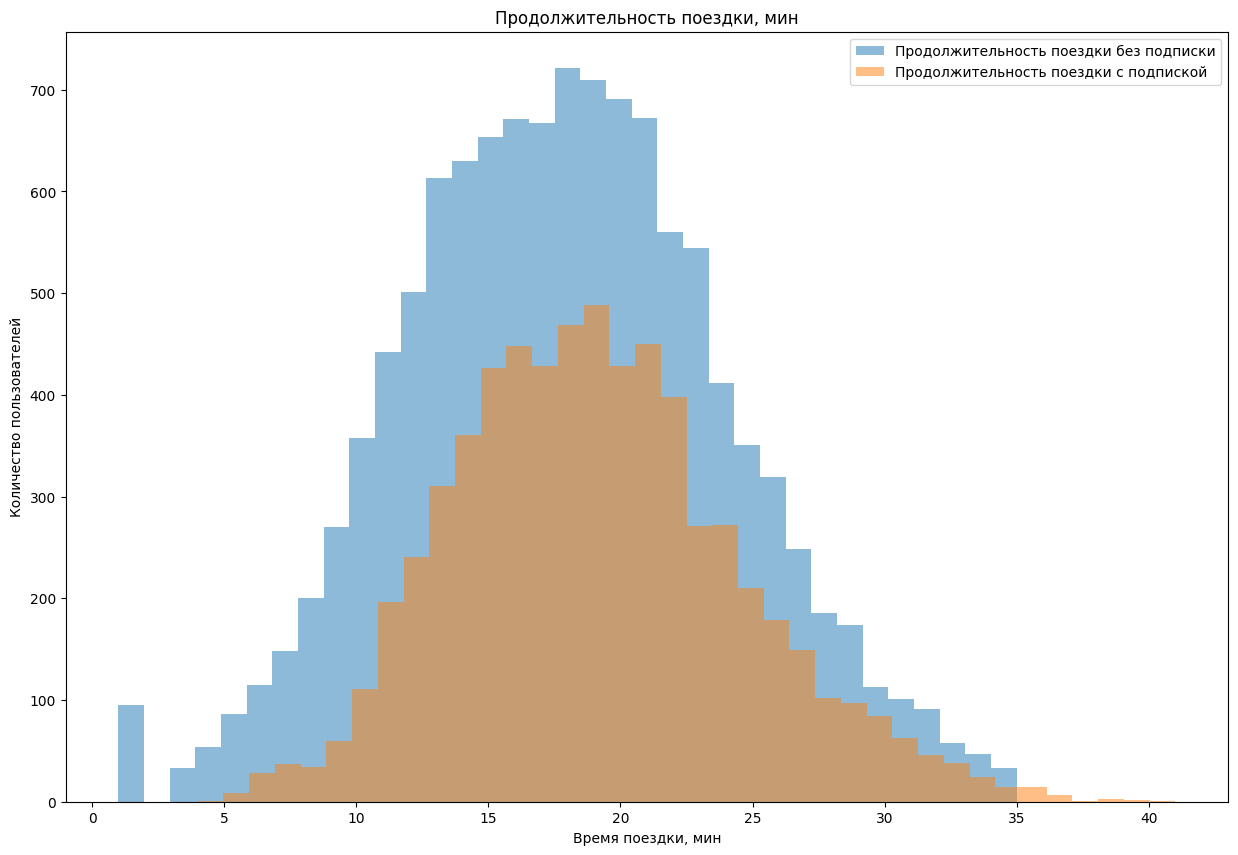

In [47]:
plt.figure(figsize=(15,10))
plt.hist(df_merge_free['duration'], alpha = 0.5, bins=35, label='Продолжительность поездки без подписки')
plt.hist(df_merge_ultra['duration'], alpha = 0.5, bins=38, label='Продолжительность поездки с подпиской')
plt.legend(loc='upper right')
plt.title('Продолжительность поездки, мин')
plt.xlabel('Время поездки, мин')
plt.ylabel('Количество пользователей')
plt.show()

**В среднем пользователи без подписки ездят на расстояния от 2500 до 4000 м, с продолжительностью поездки около 18 минут. Есть небольшой пик на расстоянии от 0 до 1000 м.**

**В среднем пользователи с подпиской ездят на расстояния от 2800 до 3500 м, со средней продолжительностью также 18 минут. Но в отличие от пользователей без подписки, можно заметить, что минимальное значение продолжительности езды составляет 4-5 минут.**

**Вывод: объединив таблицы мы получили более полную картину, рассмотрели закономерности поведения графиков для людей с подпиской и без. В целом, пока результаты не сильно расходятся с общими средними значениями.**

### Подсчёт выручки.

#### Создадим датафрейм `df_merge_free_pivot` с агрегированными данными о поездках для каждого пользователя без подписки. Найдем суммарное расстояние, количество поездок и суммарное время за каждый месяц для каждого пользователя.

In [49]:
df_merge_free_pivot = df_merge_free.pivot_table(
    index=['user_id', 'month_number'], 
    values=['distance', 'duration'], 
    aggfunc=['sum', 'count']
)

In [50]:
df_merge_free_pivot = df_merge_free_pivot.reset_index().droplevel(1, axis=1)
df_merge_free_pivot.columns = ['user_id', 'month_number', 'distance_sum', 'duration_sum', 'count', 'count_1']
df_merge_free_pivot.drop('count_1', axis= 1 , inplace= True )

**Добавим столбец с помесячной выручкой, которую принес каждый пользователь. Помесячная выручка считается по формуле: *стоимость старта поездки (50) * количество поездок + суммарное количество минут * стоимость в минуту (8)*.**

In [51]:
df_merge_free_pivot['monthly_revenue'] = (
    50 * df_merge_free_pivot['count'] + 
    df_merge_free_pivot['duration_sum'] * 8
)

In [52]:
df_merge_free_pivot.head(20)

,user_id,month_number,distance_sum,duration_sum,count,monthly_revenue
0,700,1,2515.7,15,1,170
1,700,2,13446.6,89,5,962
2,700,3,3798.3,19,1,202
3,700,4,2984.6,16,1,178
4,700,6,5927.6,29,2,332
5,700,7,4399.2,21,2,268
6,700,8,4071.7,17,1,186
7,700,10,6322.6,44,2,452
8,700,11,8735.8,32,3,406
9,701,1,2676.5,18,1,194


#### Создадим датафрейм `df_merge_ultra_pivot` с агрегированными данными о поездках для каждого пользователя c подпиской. Найдем суммарное расстояние, количество поездок и суммарное время за каждый месяц для каждого пользователя.

In [53]:
df_merge_ultra_pivot = df_merge_ultra.pivot_table(
    index=['user_id', 'month_number'], 
    values=['distance', 'duration'], 
    aggfunc=['sum', 'count']
)

In [54]:
df_merge_ultra_pivot = df_merge_ultra_pivot.reset_index().droplevel(1, axis=1)
df_merge_ultra_pivot.columns = ['user_id', 'month_number', 'distance_sum', 'duration_sum', 'count', 'count_1']
df_merge_ultra_pivot.drop('count_1', axis= 1 , inplace= True )

**Добавим столбец с помесячной выручкой, которую принес каждый пользователь. Помесячная выручка считается по формуле: *стоимость абонемента (199) + суммарное количество минут * стоимость в минуту (6)*.**

In [55]:
df_merge_ultra_pivot['monthly_revenue'] = (
    199 + df_merge_ultra_pivot['duration_sum'] * 6
)

In [56]:
df_merge_ultra_pivot.head(20)

,user_id,month_number,distance_sum,duration_sum,count,monthly_revenue
0,1,1,7027.5,42,2,451
1,1,4,754.2,7,1,241
2,1,8,6723.5,46,2,475
3,1,10,5809.9,32,2,391
4,1,11,7003.5,56,3,535
5,1,12,6751.6,28,2,367
6,2,3,10187.7,63,3,577
7,2,4,6164.4,40,2,439
8,2,6,3255.3,14,1,283
9,2,7,6780.7,48,2,487


**Вывод: мы создали 2 сводные таблицы с данными по пользователям с подпиской и без. Посчитали выручку с каждого пользователя по месяцам и записали её в отдельный столбец. Далее эти таблицы будут использоваться для проверки гипотез.**

### Проверка гипотез.

#### Гипотеза 1: Тратят ли пользователи с подпиской больше времени на поездки, чем пользователи без подписки? Если да, то действительно ли пользователи с подпиской «выгоднее» для компании?

**Будем рассматривать средние значения столбца *duration* таблиц `df_merge_ultra` и `df_merge_free`. Найдем средние значения и медианы.**

In [57]:
print('Медиана продолжительности поездок людей без подписки:', df_merge_free['duration'].median())
print('Среднее продолжительности поездок людей без подписки:', df_merge_free['duration'].mean())
print('Медиана продолжительности поездок людей с подпиской:', df_merge_ultra['duration'].median())
print('Среднее продолжительности поездок людей с подпиской:', df_merge_ultra['duration'].mean())

Медиана продолжительности поездок людей без подписки: 18.0
Среднее продолжительности поездок людей без подписки: 17.890992392807746
Медиана продолжительности поездок людей с подпиской: 19.0
Среднее продолжительности поездок людей с подпиской: 19.037692307692307


**Средняя продолжительность поездок пользователей с подпиской на минуту больше, чем пользователей без подписки.**

**Нулевая гипотеза в данном случае будет звучать так: средние значения продолжительности поездки меньше или равны. Альтернативная гипотеза - средние значения продолжительности поездки больше.**

In [59]:
alpha = 0.05

results_7 = st.ttest_ind(
    df_merge_ultra['duration'], 
    df_merge_free['duration'],
    equal_var=False,
    alternative='greater') # альтернативная гипотеза больше предполагаемой

print('p-значение:', results_7.pvalue)

if (results_7.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: пользователи с подпиской ездят дольше')
else:
    print('Не получилось отвергнуть нулевую гипотезу: пользователи с подпиской ездят меньше')

p-значение: 1.1814679253701353e-36
Отвергаем нулевую гипотезу: пользователи с подпиской ездят дольше


**Значение p-value показывает: вероятность случайно получить такое или большее различие равна 1.1814679253701353e-36, хотя средние значения продолжительности поездки из разных таблиц и не одинаковы. Теперь точно видно, что явно слишком маленькая вероятность, чтобы делать вывод о значимом сходстве между средними значениями, к тому же благодаря параметру alternative = 'greater', мы можем говорить о том, что альтернативная гипотеза больше предполагаемой нулевой, а значит гипотеза "действительно ли пользователи с подпиской имеют продолжительность поездки больше, чем пользователи без подписки" подтверждается.**

In [60]:
interested_value = 18 # продолжительность поездки в среднем от пользователя без подписки

alpha = 0.05

results_6 = st.ttest_1samp(
    df_merge_ultra['duration'], 
    interested_value,
    alternative='greater') # альтернативная гипотеза больше предполагаемой

print('p-значение:', results_6.pvalue)

if (results_6.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: пользователи с подпиской ездят дольше')
else:
    print('Не получилось отвергнуть нулевую гипотезу: пользователи с подпиской ездят меньше')

p-значение: 2.506444273842686e-50
Отвергаем нулевую гипотезу: пользователи с подпиской ездят дольше


**Второй способ проверки: мы взяли среднее значение поездки пользователей без подписки (18) и провели тест. Нулевая гипотеза: поездка равна 18 минутам. Альтернативная - поездка дольше. Тест показал, что значения поездки больше значения 18, значит пользователи с подпиской ездят больше и их значения лежат "правее".**

**Попробуем ответить на этот вопрос: действительно ли пользователи с подпиской «выгоднее» для компании?**

In [61]:
print('Среднее количество использования сервиса аренды самокатов в месяц без подписки:', df_merge_free_pivot['count'].mean())
print('Среднее количество использования сервиса аренды самокатов в месяц с подпиской:', df_merge_ultra_pivot['count'].mean())

Среднее количество использования сервиса аренды самокатов в месяц без подписки: 1.7016769638128861
Среднее количество использования сервиса аренды самокатов в месяц с подпиской: 1.4339289653651004


**Выручка с одного пользователя без подписки в месяц равна *2 поездки * (стоимость старта (50) + среднее время поездки (18) * стоимость одной минуты (8)***

**Выручка с одного пользователя с подпиской в месяц равна *стоимость абонемента (199) + 2 поездки * среднее время поездки (19) * стоимость одной минуты (6)***

In [62]:
print('Выручка с одного пользователя без подписки в месяц:', 2 * (50 + 18 * 8))
print('Выручка с одного пользователя c подпиской в месяц:', 199 + 2 * 19 * 6)

Выручка с одного пользователя без подписки в месяц: 388
Выручка с одного пользователя c подпиской в месяц: 427


**Среднее 3 раза в месяц:**

In [63]:
print('Выручка с одного пользователя без подписки в месяц:', 3 * (50 + 18 * 8))
print('Выручка с одного пользователя c подпиской в месяц:', 199 + 3 * 19 * 6)

Выручка с одного пользователя без подписки в месяц: 582
Выручка с одного пользователя c подпиской в месяц: 541


**В среднем в месяц аренду самокатов используют всего примерно по 2 раза. При таком раскладе продавать подписку выгоднее для компании, их выручка значительно выше. Более точно выручку мы рассмотрим в Гипотезе 3. Но при такой схеме, уже если средних поездок станет по 3 в месяц, а средняя продолжительность поездки не упадет, то выгоднее станут пользователи без подписки.**

#### Гипотеза 2: Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской и без за одну поездку, меньше 3130 метров?

Нулевая гипотеза: пользователи проезжают дистанцию = 3130 метров. Альтернативная гипотеза: пользователи проезжают дистанцию равную менее 3130 метров.

**Проведем тест для пользователей с подпиской:**

In [64]:
interested_distance = 3130

alpha = 0.05 # уровень статистической значимости

results_2 = st.ttest_1samp(
    df_merge_ultra['distance'], 
    interested_distance,
    alternative='less') #альтернативная гипотеза меньше предполагаемой

print('p-значение:', results_2.pvalue)

if (results_2.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.0804572631664147
Не отвергаем нулевую гипотезу


**Точно нельзя сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров. P-value  в данном случае получилось 8%, что больше статистичкой значимости 5%, но с другой стороны меньше 10%. Пока отвергать гипотезу не будем. На гистограмме выше, мы также наблюдали, что дистанции более 3000 метров встречаются часто.**

In [65]:
interested_distance = 3130

alpha = 0.05 # уровень статистической значимости

results_3 = st.ttest_1samp(
    df_merge_free['distance'], 
    interested_distance,
    alternative='less') #альтернативная гипотеза меньше предполагаемой

print('p-значение:', results_3.pvalue)

if (results_3.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 1.609526732951121e-13
Отвергаем нулевую гипотезу


**А вот пользователи без подписки ездят менее 3130 метров, что хорошо сказывается на износостойкости самокатов.**

**По результатам можно сделать вывод, что и пользователи с подпиской проезжают около 3130 метров в среднем, а пользователи без подписки - меньше этого числа.**

#### Гипотеза 3: Будет ли выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки?

**Проверим гипотезу: действительно ли пользователи с подпиской приносят выручку больше, чем пользователи без подписки.**

In [66]:
print('Медиана продолжительности поездок людей без подписки:', df_merge_free_pivot['monthly_revenue'].median())
print('Среднее продолжительности поездок людей без подписки:', df_merge_free_pivot['monthly_revenue'].mean())
print('Медиана продолжительности поездок людей с подпиской:', df_merge_ultra_pivot['monthly_revenue'].median())
print('Среднее продолжительности поездок людей с подпиской:', df_merge_ultra_pivot['monthly_revenue'].mean())

Медиана продолжительности поездок людей без подписки: 274.0
Среднее продолжительности поездок людей без подписки: 328.6413651073845
Медиана продолжительности поездок людей с подпиской: 337.0
Среднее продолжительности поездок людей с подпиской: 362.7921906022502


**Нулевая гипотеза в данном случае будет звучать так: среднее значение выручки пользователей с подпиской не больше или равно среднему значению выручки пользователей без подписки. Альтернативная гипотеза - среднее значения выручки пользователей с подпиской больше.**

In [67]:
results_4 = st.ttest_ind(
    df_merge_ultra_pivot['monthly_revenue'], 
    df_merge_free_pivot['monthly_revenue'],
    equal_var=False,
    alternative='greater') # альтернативная гипотеза больше предполагаемой

alpha = 0.05
print('p-значение:', results_4.pvalue)

if results_4.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 8.874140893976874e-40
Отвергаем нулевую гипотезу


**Значение p-value показывает: вероятность случайно получить такое или большее различие равна 8.874140893976874e-40, хотя средние значения выручки из разных таблиц и не одинаковы. Теперь точно видно, что явно слишком маленькая вероятность, чтобы делать вывод о значимом сходстве между средними значениями, к тому же благодаря параметру alternative = 'greater', мы можем говорить о том, что альтернативная гипотеза больше предполагаемой нулевой, а значит гипотеза "Будет ли выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки?" подтверждается.**

In [68]:
interested_value = 330 # выручка в среднем от пользователя без подписки

alpha = 0.05

results_5 = st.ttest_1samp(
    df_merge_ultra_pivot['monthly_revenue'], 
    interested_value,
    alternative='greater') # альтернативная гипотеза больше предполагаемой

print('p-значение:', results_5.pvalue)

if (results_5.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: пользователи с подпиской приносят больше выручки')
else:
    print('Не получилось отвергнуть нулевую гипотезу: пользователи с подпиской приносят меньше выручки')

p-значение: 9.036198210343127e-130
Отвергаем нулевую гипотезу: пользователи с подпиской приносят больше выручки


**Второй способ проверки: мы взяли среднее значение выручки пользователей без подписки (330) и провели тест. Нулевая гипотеза: выручка равна 330. Альтернативная - выручка больше. Тест показал, что значения выручки больше значения 330, значит пользователи с подпиской приносят больше выручки и их значения лежат "правее".**

#### Теоретический вопрос

**Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?**

Ответ: данная гипотеза - это гипотеза о равенстве средних для зависимых (парных) выборок. Чтобы проверить гипотезу о равенстве средних двух генеральных совокупностей для зависимых (парных) выборок в Python, применим метод `scipy.stats.ttest_rel()`. Ему достаточно передать всего два параметра: наборы данных до и после. Оба набора должны быть одинаковыми по размеру: каждое измерение должно быть проведено до и после изменения.

**Общий вывод по гипотезам:**

1. Пользователи с подпиской тратят меньше времени на поездки, чем пользователи без подписки. 

2. Нельзя сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров. Вероятнее оно будет даже больше.

3. Выручка от пользователей без подписки больше, чем от пользователей с подпиской.

### Распределения

#### Задача №1

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [69]:
def number_n(n):
    
    p = 0.1 # вероятность успеха в данном испытании
    k = 99 # количество успехов
    
    try: 
        round((1 - binom.cdf(k, n, p)), 2)
        return (round((1 - binom.cdf(k, n, p)), 2)), n
    
    except:
        return 'Ошибка'

In [70]:
for n in range(800, 1500):
    x = number_n(n)
    print (x)

(0.01, 800)
(0.01, 801)
(0.01, 802)
(0.01, 803)
(0.01, 804)
(0.01, 805)
(0.02, 806)
(0.02, 807)
(0.02, 808)
(0.02, 809)
(0.02, 810)
(0.02, 811)
(0.02, 812)
(0.02, 813)
(0.02, 814)
(0.02, 815)
(0.02, 816)
(0.02, 817)
(0.02, 818)
(0.02, 819)
(0.02, 820)
(0.02, 821)
(0.02, 822)
(0.03, 823)
(0.03, 824)
(0.03, 825)
(0.03, 826)
(0.03, 827)
(0.03, 828)
(0.03, 829)
(0.03, 830)
(0.03, 831)
(0.03, 832)
(0.03, 833)
(0.03, 834)
(0.03, 835)
(0.04, 836)
(0.04, 837)
(0.04, 838)
(0.04, 839)
(0.04, 840)
(0.04, 841)
(0.04, 842)
(0.04, 843)
(0.04, 844)
(0.05, 845)
(0.05, 846)
(0.05, 847)
(0.05, 848)
(0.05, 849)
(0.05, 850)
(0.05, 851)
(0.05, 852)
(0.06, 853)
(0.06, 854)
(0.06, 855)
(0.06, 856)
(0.06, 857)
(0.06, 858)
(0.06, 859)
(0.06, 860)
(0.07, 861)
(0.07, 862)
(0.07, 863)
(0.07, 864)
(0.07, 865)
(0.07, 866)
(0.08, 867)
(0.08, 868)
(0.08, 869)
(0.08, 870)
(0.08, 871)
(0.08, 872)
(0.09, 873)
(0.09, 874)
(0.09, 875)
(0.09, 876)
(0.09, 877)
(0.1, 878)
(0.1, 879)
(0.1, 880)
(0.1, 881)
(0.1, 882)
(0.11, 88

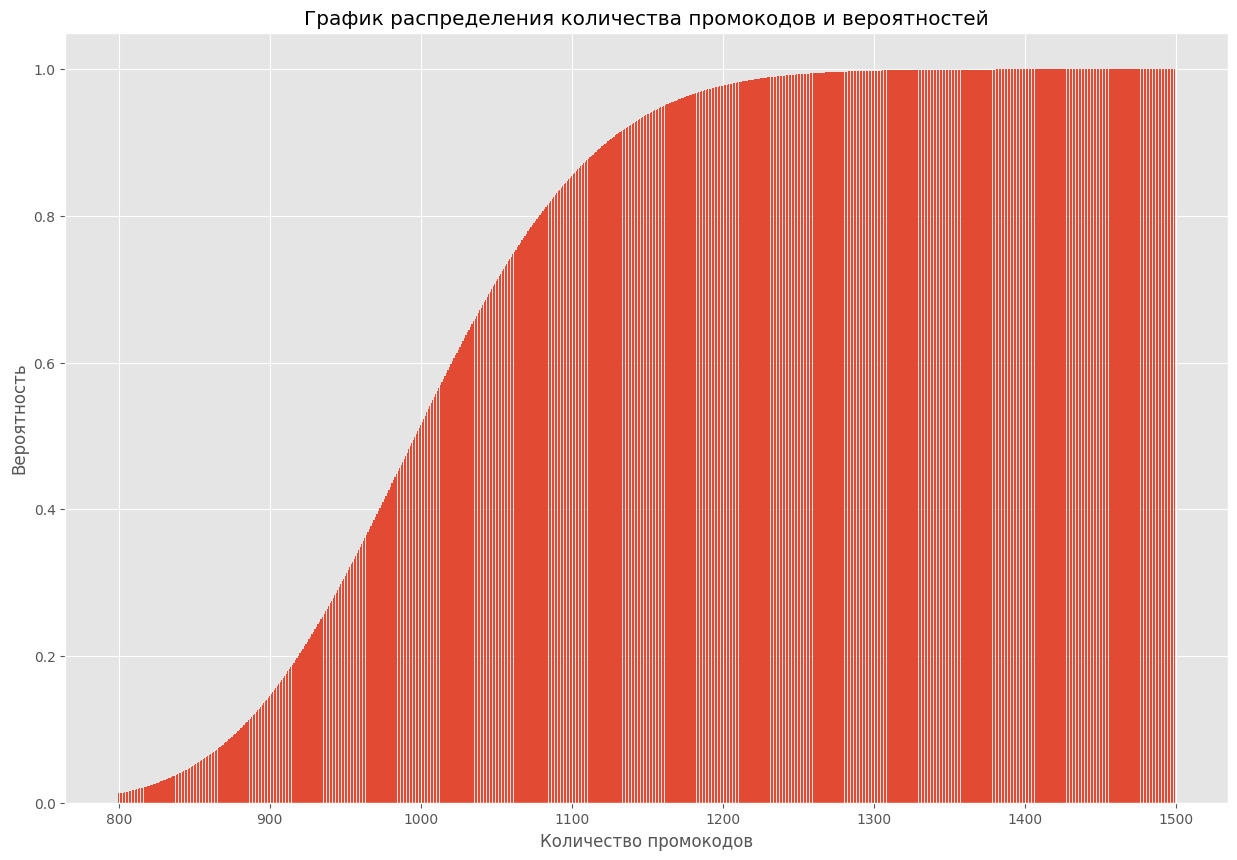

In [71]:
k = 99 # количество успехов
p = 0.1 # вероятность успеха

distr = []

for n in range(800, 1500):
    current_value = 1 - binom.cdf(k, n, p)
    distr.append(current_value)

plt.figure(figsize=(15,10))
plt.bar(range(800, 1500), distr)
plt.title('График распределения количества промокодов и вероятностей')
plt.xlabel('Количество промокодов')
plt.ylabel('Вероятность')
plt.show() 

**Видим, что вероятность 95% для успехов равных 99 достигается при количестве промокодов - 1156. Поэтому ответ на вопрос: минимальное количество промокодов которое нужно разослать, чтобы вероятность не выполнить план была примерно 5% - 1156 промокодов. А чтобы вероятность выполнить план была 100% достаточно отправить более 1262 промокодов!**

#### Задача №2

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

**Построим график биномиального распределения и нормального распределения, проверим, выполняется ли условие апроксимации и сравним эти графики.**

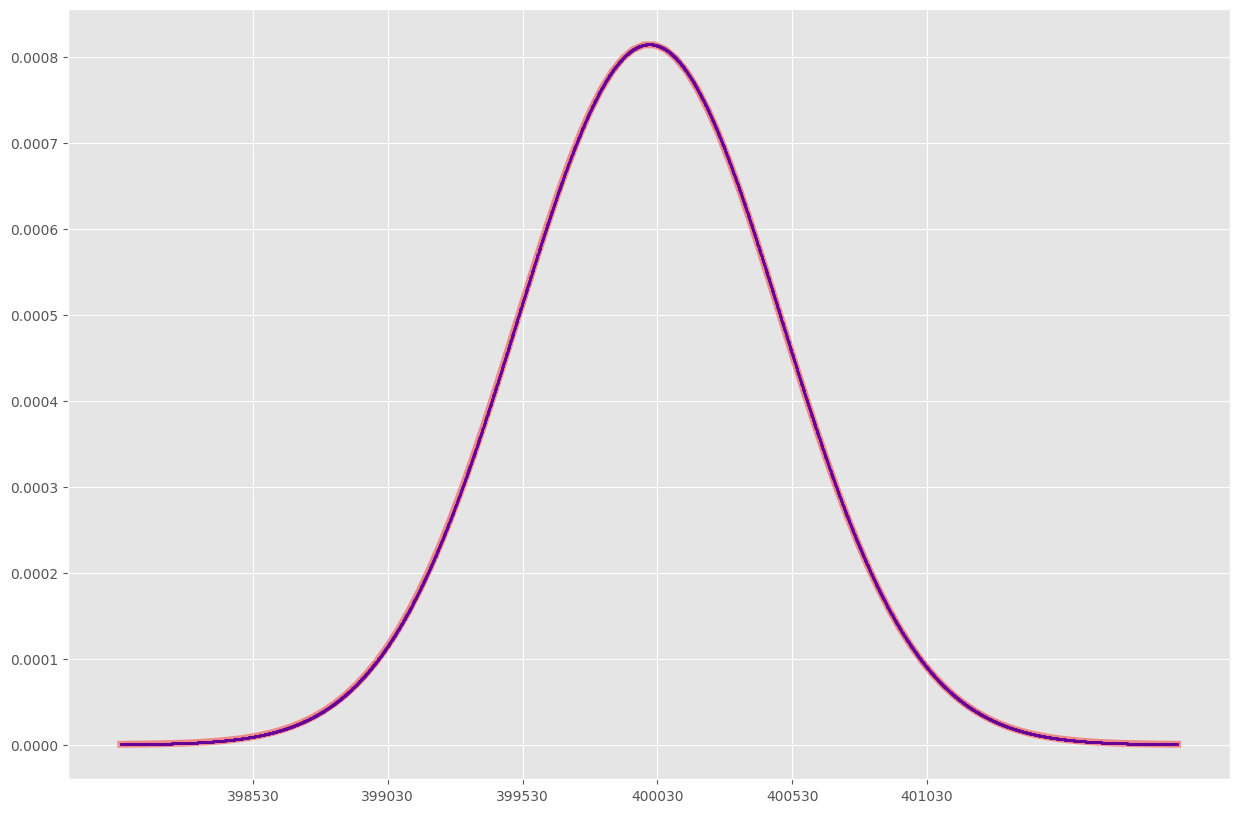

Условие выполняется


In [74]:
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>

def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
plt.figure(figsize=(15,10))
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 5
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=1)

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения

mu = n * p
sigma = sqrt(n * p * (1 - p))
 
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.4
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=5, alpha=0.4)
 
# зададим подписи по оси x в пределах ± 3 ст.отклонений от мат.ожидания
# (последний аргумент в методе range - интервал между подписями)
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 500))
ax.set_xticks(x_ticks)

plt.show()

# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие выполняется')
else:
    print('Условие не выполняется')

**Оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.**

In [75]:
n = 1000000
p = 0.4

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr_1 = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399.5 тысяч
print('Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей:', distr_1.cdf(399500))


Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей: 0.15371708296369768


**Вероятность 15.4%.**

### Общий вывод

На анализ были представлены 3 датасета от сервиса аренды самокатов GoFast: пользователи — `users_go.csv`, поездки — `rides_go.csv`, подписки - `subscriptions_go.csv`. Была проведена предобработка данных, убраны дубликаты, изменены типы данных, а также данные три таблицы были объединены в одну общую, для дальнейшего исследования зависимостей одних параметров от других.

**В данной таблице были изучены и описаны следующие параметры:**

1. Частота встречаемости городов - наиболее часто пользуются сервисом аренды самокатов в Пятигорске, а наименее - в Москве.

2. Рассмотрел соотношение пользователей с подпиской и без подписки - пользователей без подписки (54.4%) больше, чем пользователей с подпиской (45.6%).

3. Рассмотрел возраст пользователей - средний возраст пользователей сервиса аренды самокатов - 25 лет.

4. Рассмотрел расстояние, которое пользователь преодолевает за одну поездку - в среднем около 3000 метров.

5. Рассмотрел продолжительность поездок - в среднем около 18 минут.

6. В среднем пользователи без подписки ездят на расстояния от 2500 до 4000 м, с продолжительностью поездки около 18 минут. В среднем пользователи с подпиской ездят на расстояния от 2800 до 3500 м, со средней продолжительностью также 18 минут.

**Произвели подсчет выручки:**

Для каждого типа пользователя составили свои сводные таблицы со значениями выручки каждого пользователя за каждый месяц.

**Проверили гипотезы:**

1. Тратят ли пользователи с подпиской больше времени на поездки? - Гипотезу подтвердили: пользователи с подпиской используют сервис аренды самокатов дольше пользователей без подписки.

2. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров? - Гипотезу не отвергли.

3. Будет ли выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки? - Гипотезу подтвердили: выручка от пользователей с подпиской больше, чем от пользователей без подписки.

**Проверили некоторые маркетинговые задачи:**

1. Определили количество промокодов необходимых для того, чтобы как минимум 100 пользователей продлили подписку.

2. Оценили какова вероятность того, что push-уведомление откроют не более 399,5 тыс раз из миллиона отосланнных.